Условия и требования:
- (+) Разбить модель на обучающую и валидационную (тестовую) выборки
- (+) Модель только на полносвязных слоях
- (+) Модель со сверточными слоями
- (-) Разное количество слоев (и нейронов в слоях)
- (-) Дропаут
- (-) Batch Normalization
- (+) Различные функции активации
- (-) Различная инициализация весов
- (-) Различные оптимизаторы
- (-) Различные расписания обучения (learning rate scheduler)
- (-) Разные размеры batch-а и скорости обучения

Import libraries

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchmetrics

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm.notebook import tqdm

import pandas as pd

import random

import typing

print(torch.__version__)
print(torchvision.__version__)

2.0.0+cu117
0.15.1+cu117


Some constants

In [2]:
BATCH_SIZE = 32
NUM_WORKERS = 10
SEED = 42
TRAIN_MODEL0 = True
TRAIN_MODEL1 = True
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Load our dataset

In [3]:
train_data = datasets.FashionMNIST(
    root="data1",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
test_data = datasets.FashionMNIST(
    root="data1",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
len(train_data), len(test_data)

(60000, 10000)

In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

## Visualising

Image shape:torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

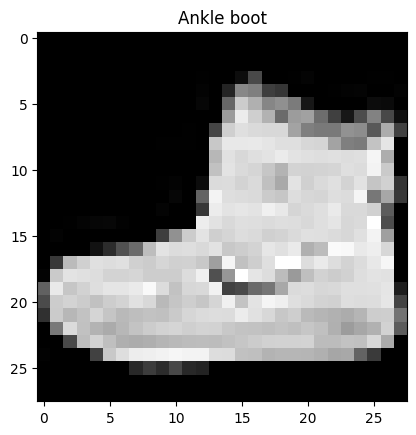

In [5]:
image, label = train_data[0]
print(f"Image shape:{image.shape}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

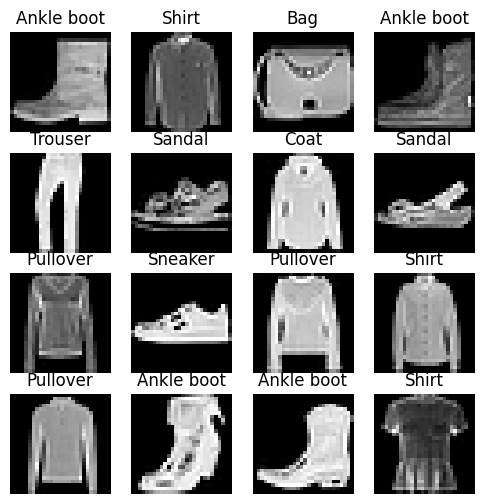

In [6]:
torch.manual_seed(SEED)
fig = plt.figure(figsize=(6, 6))
rows, cols = 4, 4
for i in range (1, rows*cols+1):
    rnd_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[rnd_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## Prepare dataloaders

In [7]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False, # Easier this way
                             num_workers=NUM_WORKERS)

Checking batch

In [8]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

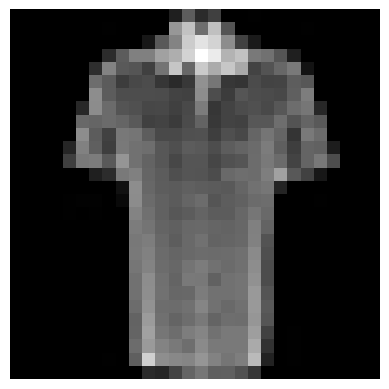

In [9]:
torch.manual_seed(SEED)

rnd_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[rnd_idx], train_labels_batch[rnd_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.axis(False)


## Building a model

In [10]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 outputs_shape: int):
        super().__init__()
        self.layerstack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=outputs_shape),
        )
    def forward(self, x):
        return self.layerstack(x)

In [11]:
torch.manual_seed(SEED)

model_0 = FashionMNISTModelV0(
    input_shape=28 * 28, # H * W
    hidden_units=10,
    outputs_shape=len(class_names)
).to("cpu")


### Loss function, Optimizer, Evaluation metric, Timing

In [12]:
LR0 = 0.1

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=LR0
)

accuracy_fn_cpu = torchmetrics.Accuracy(
    task='multiclass',
    num_classes=len(class_names),
    device="cpu"
)

accuracy_fn_device = torchmetrics.Accuracy(
    task='multiclass',
    num_classes=len(class_names),
    device=device
).to(device)

# def accuracy_fn(y_true, y_pred):
#     correct = torch.eq(y_true, y_pred).sum().item()
#     acc = (correct / len(y_pred)) * 100
#     return acc

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    total_time = end - start
    print(f"Total time on {device}: {total_time:.3f} seconds")
    return total_time



## Training-testing loop

In [13]:
EPOCHS = 3
torch.manual_seed(SEED)

if TRAIN_MODEL0:
    train_time_start = timer()
    for epoch in tqdm(range(EPOCHS)):
        print(f"Epoch: {epoch}\n-------")

        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            model_0.train()
            y_pred = model_0(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss # accumulate train loss for batch

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 400 == 0:
                print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

        train_loss /= len(train_dataloader)

        test_loss, test_acc = 0, 0
        model_0.eval()
        with torch.inference_mode():
            for X_test, y_test in test_dataloader:
                test_pred = model_0(X_test)
                test_loss += loss_fn(test_pred, y_test)
                test_acc += accuracy_fn_cpu(y_test, test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)
        print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

    train_time_end = timer()
    train_time_model_0 = print_train_time(
        train_time_start,
        train_time_end,
        device=str(next(model_0.parameters()).device)
    )


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.5904 | Test loss: 0.5095, Test acc: 0.8204
Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


KeyboardInterrupt: 

## Inference (eval)

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device,
               train_time: float = 0
               ):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for (X, y) in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "name": model.__class__.__name__,
        "loss": loss.item(),
        "acc": acc.item(),
        "train_time": train_time
    }

In [ ]:
model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn_cpu, device="cpu", train_time=train_time_model_0)
model_0_results

Trying GPU and non-linear (Building device-agnostic code)

In [ ]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layerstack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            nn.ReLU(),
            # nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.layerstack(x)

In [ ]:
torch.manual_seed(SEED)

model_1 = FashionMNISTModelV1(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

In [ ]:
LR1 = 0.1

optimizer1 = torch.optim.SGD(
    params=model_1.parameters(),
    lr=LR1
)

In [ ]:
def train_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_function: typing.Callable,
        optimizer: torch.optim.Optimizer,
        eval_function: typing.Callable,
        device: torch.device,
) -> (float, float):
    """
    :return: loss, acc
    """


    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for X_train, y_train in tqdm(dataloader, desc="Train batches"):
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        y_train_pred = model(X_train)

        loss = loss_function(y_train_pred, y_train)
        train_loss += loss

        train_acc += eval_function(y_train, y_train_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

def test_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_function: typing.Callable,
        eval_function: typing.Callable,
        device: torch.device
) -> (float, float):
    """
    :return: loss, acc
    """
    model.eval()
    test_acc, test_loss = 0, 0
    with torch.inference_mode():
        for X_test, y_test in tqdm(dataloader, desc="Test batches"):
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_test_pred = model(X_test)
            test_loss += loss_function(y_test_pred, y_test)
            test_acc += eval_function(y_test, y_test_pred.argmax(dim=1))
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    return test_loss, test_acc

In [ ]:
EPOCHS1 = 3

torch.manual_seed(SEED)
train_time_start = timer()

for epoch in tqdm(range(EPOCHS1), desc="Epochs"):
    print(f"Epoch {epoch+1}\n-------")
    train_loss, train_acc = train_step(
        model=model_1,
        dataloader=train_dataloader,
        loss_function=loss_fn,
        optimizer=optimizer1,
        eval_function=accuracy_fn_device,
        device=device
    )


    print(f"---Train--- \nAcc: {train_acc}\nLoss: {train_loss}\n")

    test_loss, test_acc = test_step(
        model=model_1,
        dataloader=test_dataloader,
        loss_function=loss_fn,
        eval_function=accuracy_fn_device,
        device=device
    )

    print(f"---Test--- \nAcc: {test_acc}\nLoss: {test_loss}\n")

train_time_end = timer()
train_time_model_1 = print_train_time(start=train_time_start, end=train_time_end, device=str(next(model_1.parameters()).device))

In [ ]:
model_1_results = eval_model(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn_device,
    device=device,
    train_time=train_time_model_1
)
model_1_results

## Convolutional (tinyVGG)

In [ ]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape, # channels
                out_channels=hidden_units,
                kernel_size= 3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features= output_shape * 7 * 7,
                out_features=output_shape
            )
        )
    def forward(self, x):
        x = self.conv_block1(x)
        # print(x.shape)
        x = self.conv_block2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [ ]:
torch.manual_seed(SEED)
model_2 = FashionMNISTModelV2(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

ээээээээксперименты

In [ ]:
torch.manual_seed(SEED)

images = torch.randn(size=(32, 3, 64, 64))
test_image= images[0]

print(images.shape)
print(test_image.shape)

conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)

conv_out = conv_layer(test_image)
print(conv_out.shape)
maxpool_layer = nn.MaxPool2d(kernel_size=2)
maxpool_out = maxpool_layer(conv_out)
print(maxpool_out.shape)

In [ ]:
rand_batch_tensor = torch.randn(size=(32,1,28,28)) # проверить сколько надо на выходном слое
# model_2(rand_batch_tensor.to(device))

конец экспериментов

In [ ]:
# loss_fn SAME

LR2 = 0.1

optimizer2 = torch.optim.SGD(params=model_2.parameters(), lr=LR2)


In [ ]:
EPOCHS2 = 3
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
train_time_start = timer()

for epoch in tqdm(range(EPOCHS2), desc="Epochs"):
    print(f"Epoch {epoch+1}\n-------")
    train_loss, train_acc = train_step(
        model=model_2,
        dataloader=train_dataloader,
        optimizer=optimizer2,
        loss_function=loss_fn,
        eval_function=accuracy_fn_device,
        device=device
    )
    print(f"---Train--- \nAcc: {train_acc}\nLoss: {train_loss}\n")
    test_loss, test_acc = test_step(
        model=model_2,
        dataloader=test_dataloader,
        loss_function=loss_fn,
        eval_function=accuracy_fn_device,
        device=device
    )
    print(f"---Test--- \nAcc: {test_acc}\nLoss: {test_loss}\n")
train_time_end = timer()
train_time_model_2 = print_train_time(train_time_start, train_time_end, device=device)

In [ ]:
model_2_results = eval_model(
    model = model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn_device,
    device=device,
    train_time=train_time_model_2
)
model_2_results

In [ ]:
pd.DataFrame([ model_0_results, model_1_results, model_2_results])

## Evaluation with best model

In [ ]:
def make_prediction(
        model: torch.nn.Module,
        data: list,
        device: torch.device = device
):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)


In [ ]:
# random.seed(SEED)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [ ]:
pred_probs = make_prediction(model=model_2, data=test_samples, device=device)
pred_classes = pred_probs.argmax(dim=1)

In [ ]:
plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i, sample in enumerate(test_samples):
    plt.subplot(rows, cols, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_wrong_text = f"Pred {pred_label} | True: {truth_label}"
    title_correct_text = pred_label
    if pred_label==truth_label:
        plt.title(title_correct_text, fontsize=10, c="g")
    else:
        plt.title(title_wrong_text, fontsize=10, c="r")
    plt.axis(False)